#### Importing Libraries

In [1]:
#Necessary libraries

from dateutil.parser import parser
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

#### Read input files into a dataframe

In [2]:
#Read .csv files

df1 = pd.read_csv('mass_shootings.csv',      parse_dates=['Incident Date'])  #Contains 2014 - 2020 data

df2 = pd.read_csv('mass_shootings2021.csv',  parse_dates=['Incident Date'])  #Contains 2020 - 2021 data

df3 = pd.read_csv('mass_shootings2022.csv',  parse_dates=['Incident Date'])  #Contains 2021 - 2022 data

In [3]:
#Merge all the DataFrames into one DataFrame

df = pd.concat([df3, df2, df1], ignore_index=True)

In [4]:
dfs = [df1, df2, df3, df]

for df in dfs:
    print(df.shape)

(2373, 11)
(690, 8)
(647, 8)
(3710, 11)


#### Understanding the history of mass shootings from the data

In [5]:
#Display top 10 rows of the DataFrame

df.head(10)

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,Full Address,Latitude,Longitude
0,2491656.0,2022-12-31,Arizona,Phoenix,4201 N 19th Ave,0,9,NaN,NaN,NaN,NaN
1,2492253.0,2022-12-31,Alabama,Mobile,200 block of Dauphin St,1,8,NaN,NaN,NaN,NaN
2,2491054.0,2022-12-30,Tennessee,Memphis,E Brooks Rd,1,3,NaN,NaN,NaN,NaN
3,2490925.0,2022-12-30,Texas,Humble,4800 block of Park Square Ln,2,3,NaN,NaN,NaN,NaN
4,2489614.0,2022-12-28,New York,Bronx,851 E Tremont Ave,1,3,NaN,NaN,NaN,NaN
5,2490150.0,2022-12-28,Texas,Dallas,9500 block of Scyene Rd,0,6,NaN,NaN,NaN,NaN
6,2488952.0,2022-12-27,District of Columbia,Washington,2300 block of Pennsylvania Ave SE,0,4,NaN,NaN,NaN,NaN
7,2489345.0,2022-12-27,Ohio,Columbus,900 block of Bellows Ave,0,5,NaN,NaN,NaN,NaN
8,2489124.0,2022-12-27,California,Eureka,4000 block of Crane St,2,2,NaN,NaN,NaN,NaN
9,2488209.0,2022-12-26,Louisiana,New Orleans,2031 St Maurice Ave,2,4,NaN,NaN,NaN,NaN


In [6]:
#Information about the DataFrame df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3710 entries, 0 to 3709
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Incident ID     2441 non-null   float64       
 1   Incident Date   3710 non-null   datetime64[ns]
 2   State           3710 non-null   object        
 3   City Or County  3710 non-null   object        
 4   Address         3696 non-null   object        
 5   # Killed        3710 non-null   int64         
 6   # Injured       3710 non-null   int64         
 7   Operations      0 non-null      float64       
 8   Full Address    2368 non-null   object        
 9   Latitude        2373 non-null   float64       
 10  Longitude       2373 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 319.0+ KB


##### Operations column has no data, so we can drop it before splitting the data. Theoretically, the three important columns for time series analysis i.e., Injured, Killed and Incident date has same number of records.

In [7]:
#Descriptive statistics of the DataFrame df, including statistics for both numerical and non-numerical columns

df.describe(include='all', datetime_is_numeric=True)

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,Full Address,Latitude,Longitude
count,2.441000e+03,3710,3710,3710,3696,3710.000000,3710.000000,0.0,2368,2373.000000,2373.000000
unique,NaN,NaN,49,994,3663,NaN,NaN,NaN,2364,NaN,NaN
top,NaN,NaN,Illinois,Chicago,800 block of N Pine St,NaN,NaN,NaN,"101 W Maryland St Indianapolis, Indiana",NaN,NaN
freq,NaN,NaN,381,276,2,NaN,NaN,NaN,2,NaN,NaN
mean,1.603831e+06,2019-03-02 06:29:41.563342336,NaN,NaN,NaN,1.072507,4.183827,NaN,NaN,36.923611,-90.028490
min,9.219400e+04,2014-01-01 00:00:00,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,25.521759,-149.880150
25%,1.440510e+06,2016-11-04 06:00:00,NaN,NaN,NaN,0.000000,3.000000,NaN,NaN,33.602473,-94.494259
50%,1.966181e+06,2019-06-24 12:00:00,NaN,NaN,NaN,1.000000,4.000000,NaN,NaN,37.803316,-87.603884
75%,2.227035e+06,2021-08-05 12:00:00,NaN,NaN,NaN,1.000000,5.000000,NaN,NaN,40.739827,-80.269457
max,2.492253e+06,2022-12-31 00:00:00,NaN,NaN,NaN,59.000000,441.000000,NaN,NaN,61.217790,-67.451052


##### The data shows that the number of people injured in these incidents ranges from zero to 441, while the number of people killed ranges from zero to 59. On average, more people were injured than killed (4.18 versus 1.07), and there is also more variation in the number of people injured (with a range of 7.54) compared to the number of people killed (with a range of 2.03).

##### When looking at specific cities, Chicago has the highest number of incidents. The data covers January 1st, 2014, to December 31st, 2022. When analyzing by state, Illinois has the highest number of shootings.

In [8]:
# Top 20 incidents sorted by number killed first and then by number injured

df_top10 = df.nlargest(10, ['# Killed', '# Injured'], keep='all')

df_top10['Rank'] = df_top10[['# Killed', '# Injured']].apply(tuple, axis=1).rank(method='dense', ascending=False).astype(int)

df_top10 = df_top10.set_index('Rank')

df_top10

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,Full Address,Latitude,Longitude
Rank,,,,,,,,,,,
1,NaN,2017-10-01,Nevada,Las Vegas,3950 Las Vegas Blvd S,59,441,NaN,"3950 Las Vegas Blvd S Las Vegas, Nevada",36.093392,-115.176337
2,NaN,2016-06-12,Florida,Orlando,1912 S Orange Ave,50,53,NaN,"1912 S Orange Ave Orlando, Florida",28.519612,-81.376846
3,NaN,2017-11-05,Texas,Sutherland Springs,216 4th St,27,20,NaN,"216 4th St Sutherland Springs, Texas",29.273218,-98.056343
4,1466705.0,2019-08-03,Texas,El Paso,7101 Gateway Blvd,23,23,NaN,"7101 Gateway Blvd El Paso, Texas",31.776725,-106.384278
5,2310278.0,2022-05-24,Texas,Uvalde,715 Old Carrizo Rd,22,17,NaN,NaN,NaN,NaN
6,NaN,2018-02-14,Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17,NaN,"5901 Pine Island Rd Pompano Beach (Parkland), ...",26.304503,-80.269457
7,456893.0,2015-12-02,California,San Bernardino,1365 South Waterman Avenue,16,19,NaN,"1365 South Waterman Avenue San Bernardino, Cal...",34.075564,-117.277623
8,NaN,2019-05-31,Virginia,Virginia Beach,2405 Courthouse Drive,13,4,NaN,"2405 Courthouse Drive Virginia Beach, Virginia",36.751016,-76.057412
9,NaN,2018-11-07,California,Thousand Oaks,99 Rolling Oaks Dr,13,2,NaN,"99 Rolling Oaks Dr Thousand Oaks, California",34.176616,-118.874849


In [9]:
# Top 20 incidents sorted by number injured first and then by number killed

top10 = df.nlargest(10, ['# Injured', '# Killed'], keep='all')

ranked = top10.assign(Rank=top10[['# Injured', '# Killed']].apply(lambda row: sum(row), axis=1)
                      .rank(method='dense', ascending=False).astype(int))

df1_top10 = ranked.set_index('Rank')

df1_top10

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,Full Address,Latitude,Longitude
Rank,,,,,,,,,,,
1,NaN,2017-10-01,Nevada,Las Vegas,3950 Las Vegas Blvd S,59,441,NaN,"3950 Las Vegas Blvd S Las Vegas, Nevada",36.093392,-115.176337
2,NaN,2016-06-12,Florida,Orlando,1912 S Orange Ave,50,53,NaN,"1912 S Orange Ave Orlando, Florida",28.519612,-81.376846
5,2348384.0,2022-07-04,Illinois,Highland Park,Central Ave and 2nd St,7,30,NaN,NaN,NaN,NaN
8,2257739.0,2022-03-19,Arkansas,Dumas,611 Highway 65 S,1,26,NaN,NaN,NaN,NaN
9,NaN,2017-07-01,Arkansas,Little Rock,220 W 6th St,0,25,NaN,"220 W 6th St Little Rock, Arkansas",34.743509,-92.273262
4,1466705.0,2019-08-03,Texas,El Paso,7101 Gateway Blvd,23,23,NaN,"7101 Gateway Blvd El Paso, Texas",31.776725,-106.384278
7,1492441.0,2019-08-31,Texas,Odessa,8250 TX 191,8,23,NaN,"8250 TX 191 Odessa, Texas",31.924637,-102.284660
3,NaN,2017-11-05,Texas,Sutherland Springs,216 4th St,27,20,NaN,"216 4th St Sutherland Springs, Texas",29.273218,-98.056343
10,2019622.0,2021-05-30,Florida,Hialeah,7630 NW 186th St,3,20,NaN,NaN,NaN,NaN


In [10]:
#Number of instances where number of killed are more than number of injured

df.loc[df['# Injured'] < df['# Killed']].index.size

367

In [11]:
#Checking for the addresses that appears more than once

df[df.duplicated(['Address'], keep=False)]

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,Full Address,Latitude,Longitude
112,2438723.0,2022-10-15,Mississippi,Itta Bena,NaN,2,7,NaN,NaN,NaN,NaN
152,2424602.0,2022-09-23,California,Castroville,NaN,0,4,NaN,NaN,NaN,NaN
172,2412289.0,2022-09-11,Michigan,Grand Rapids,NaN,0,4,NaN,NaN,NaN,NaN
179,2410704.0,2022-09-08,Minnesota,Minneapolis,626 W Broadway Ave,0,4,NaN,NaN,NaN,NaN
242,2381371.0,2022-08-07,Pennsylvania,Pittsburgh,1700 block of Brighton Pl,1,3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3303,359830.0,2015-06-17,South Carolina,Charleston,110 Calhoun Street,9,0,NaN,"110 Calhoun Street Charleston, South Carolina",32.787511,-79.933094
3352,335903.0,2015-05-07,Ohio,Cincinnati,2300 block of Baltimore Avenue,0,4,NaN,"2300 block of Baltimore Avenue Cincinnati, Ohio",39.149724,-84.561468
3401,299344.0,2015-03-01,Michigan,Detroit,9855 Chalmers St,1,5,NaN,"9855 Chalmers St Detroit, Michigan",42.411949,-82.969337
3594,152468.0,2014-06-29,Louisiana,New Orleans,700 block of Bourbon St,1,9,NaN,"700 block of Bourbon St New Orleans, Louisiana",29.958607,-90.065457


In [12]:
#Checking for the street and city addresses that appears more than once

df[df.duplicated(['Address', 'City Or County'], keep=False)]

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,Full Address,Latitude,Longitude
179,2410704.0,2022-09-08,Minnesota,Minneapolis,626 W Broadway Ave,0,4,NaN,NaN,NaN,NaN
242,2381371.0,2022-08-07,Pennsylvania,Pittsburgh,1700 block of Brighton Pl,1,3,NaN,NaN,NaN,NaN
270,2373050.0,2022-07-29,Maryland,Baltimore,3100 block of W North Ave,2,2,NaN,NaN,NaN,NaN
329,2349723.0,2022-07-05,New York,Rochester,485 N Clinton Ave,1,3,NaN,NaN,NaN,NaN
347,2346422.0,2022-07-01,Illinois,Chicago,3800 block of W Monroe St,0,4,NaN,NaN,NaN,NaN
378,2333154.0,2022-06-16,California,Oakland,316 14th St,1,4,NaN,NaN,NaN,NaN
381,2328265.0,2022-06-12,Indiana,Gary,1700 Grant St,2,4,NaN,NaN,NaN,NaN
457,2298872.0,2022-05-10,Maryland,Baltimore,2800 block of Boarman Ave,0,5,NaN,NaN,NaN,NaN
536,2265029.0,2022-03-26,Ohio,Cleveland,1437 St Clair Ave NE,0,4,NaN,NaN,NaN,NaN
650,2200968.0,2021-12-30,Pennsylvania,Philadelphia,5100 block of Germantown Ave,0,7,NaN,NaN,NaN,NaN


#### Data Wrangling

In [13]:
# Calculate the mean of numerical columns

numerical_mean = df.select_dtypes(include=['int64', 'float64']).mean()

In [14]:
# Replace null values in numerical columns with the mean

df.fillna(numerical_mean, inplace=True)

In [15]:
# Replace null values in non-numerical columns with 'OTHERS'

df.fillna('OTHERS', inplace=True)

In [16]:
# Replace null values in non-numerical columns with 'OTHERS'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3710 entries, 0 to 3709
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Incident ID     3710 non-null   float64       
 1   Incident Date   3710 non-null   datetime64[ns]
 2   State           3710 non-null   object        
 3   City Or County  3710 non-null   object        
 4   Address         3710 non-null   object        
 5   # Killed        3710 non-null   int64         
 6   # Injured       3710 non-null   int64         
 7   Operations      3710 non-null   object        
 8   Full Address    3710 non-null   object        
 9   Latitude        3710 non-null   float64       
 10  Longitude       3710 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 319.0+ KB


#### Understanding the data for time series analysis

In [17]:
# convert dataframe to monthly time series
df['# Victims'] = df.loc[:, ['# Injured', '# Killed']].sum(axis=1)
df.sort_values(['Incident Date', 'State'], inplace=True)
df['Cumulative Victims Same Year'] = df.groupby(df['Incident Date'].dt.year).agg({'# Victims': 'cumsum'})
df.set_index('Incident Date', inplace=True)

df_ts = df.drop(['Address', 'City Or County', 'Incident ID', 'State', 'Latitude', 'Longitude'], axis=1)
df_ts = df_ts.resample('M').sum().drop('Cumulative Victims Same Year', axis=1)
df_ts.index.rename('Month Ending In', inplace=True)
df_ts['Cumulative Victims Same Year'] = df_ts.groupby(df_ts.index.year).agg({'# Victims': 'cumsum'})
df_ts['Year'], df_ts['Month'] = df_ts.index.year, df_ts.index.month


In [18]:
df_ts.head(15)

,# Killed,# Injured,# Victims,Cumulative Victims Same Year,Year,Month
Month Ending In,,,,,,
2014-01-31,15,64,79,79,2014,1
2014-02-28,23,63,86,165,2014,2
2014-03-31,13,62,75,240,2014,3
2014-04-30,16,90,106,346,2014,4
2014-05-31,23,85,108,454,2014,5
2014-06-30,18,120,138,592,2014,6
2014-07-31,27,139,166,758,2014,7
2014-08-31,32,151,183,941,2014,8
2014-09-30,18,96,114,1055,2014,9


#### As we doing time series analysis on a montly basis, we need to consider the Victims column as target.

#### Testing for Stationarity

In [19]:
# Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

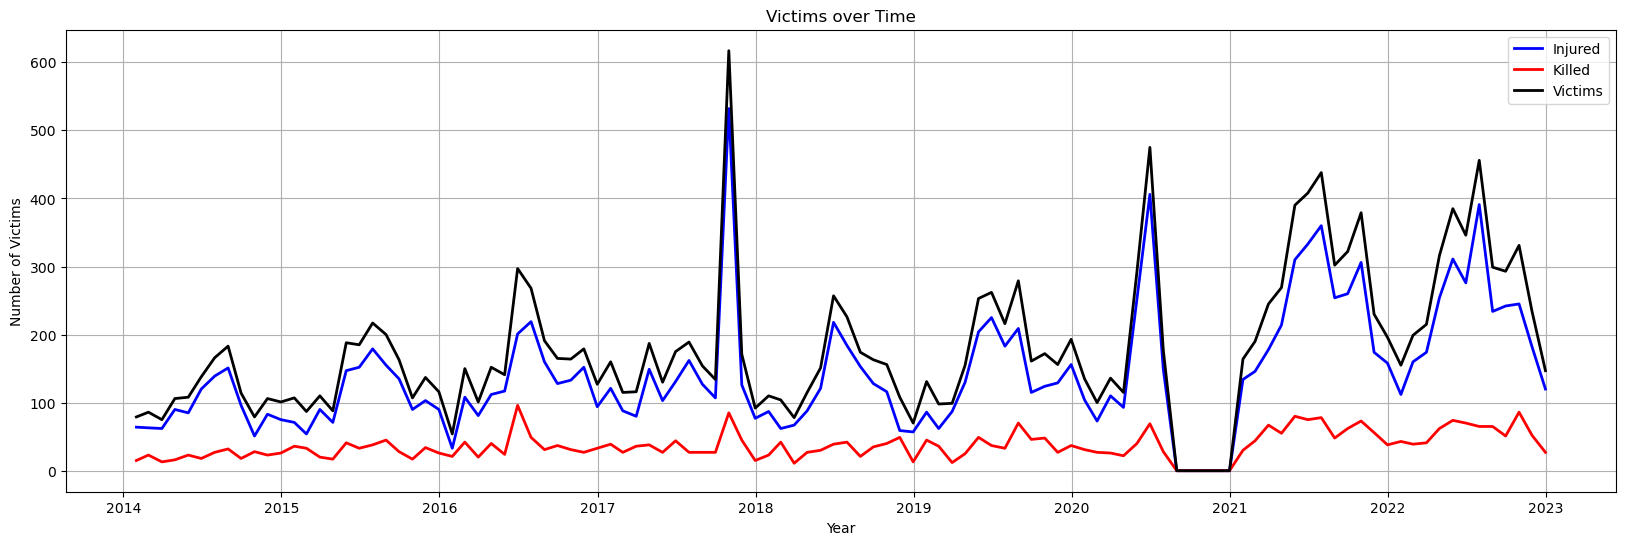

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))  # set the size of the plot
ax.plot(df_ts.index, df_ts['# Injured'], color='blue', linewidth=2, label='Injured')  # add a blue line for the injured time series
ax.plot(df_ts.index, df_ts['# Killed'], color='red', linewidth=2, label='Killed')  # add a red line for the killed time series
ax.plot(df_ts.index, df_ts['# Victims'], color='black', linewidth=2, label='Victims')  # add a black line for the victim time series
ax.set_xlabel('Year')  # add an x-axis label
ax.set_ylabel('Number of Victims')  # add a y-axis label
ax.set_title('Victims over Time')  # add a title to the plot
ax.legend()  # add a legend to the plot
ax.grid(True)  # add a grid to the plot
plt.show()  # display the plot

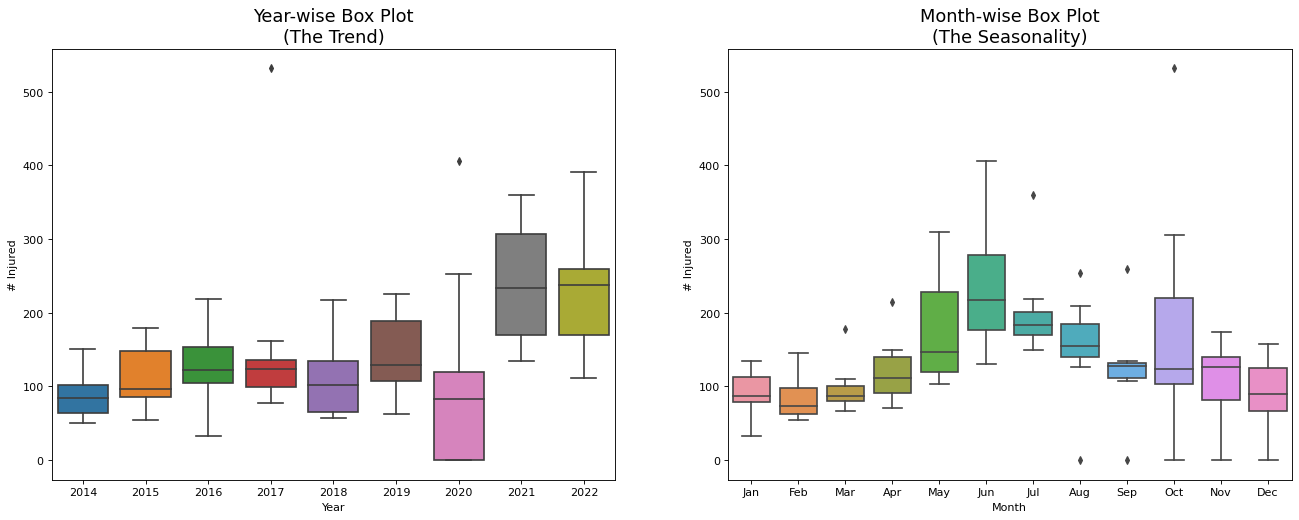

In [21]:
df_ts['Month'] = [d.strftime('%b') for d in df_ts.index]
years = df_ts['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='# Injured', data=df_ts, ax=axes[0])
sns.boxplot(x='Month', y='# Injured', data=df_ts.loc[~df_ts.Year.isin([2014, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

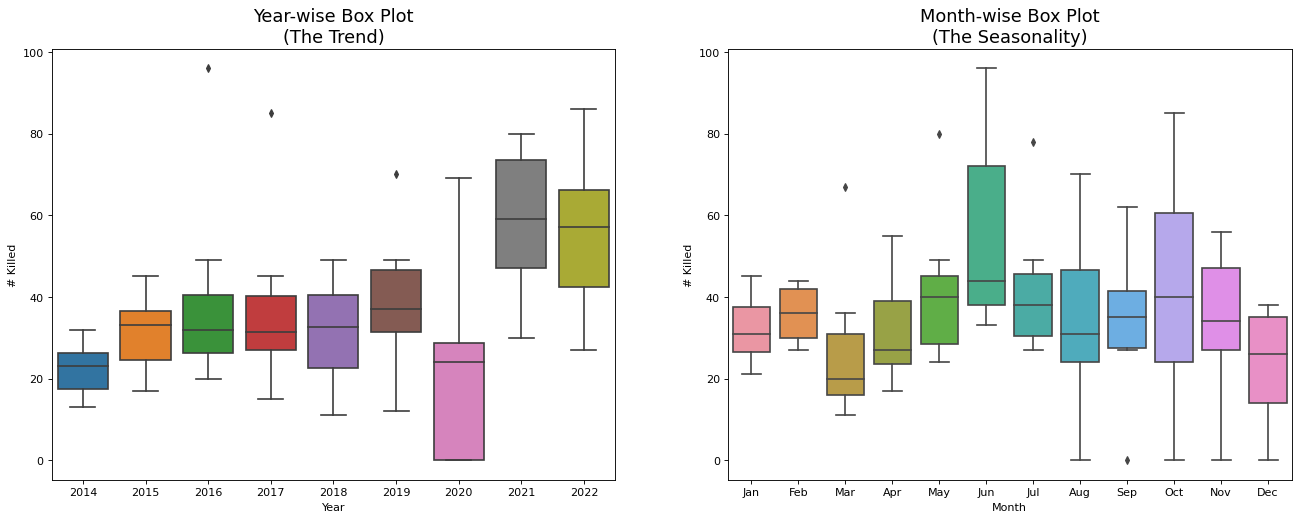

In [22]:
df_ts['Month'] = [d.strftime('%b') for d in df_ts.index]
years = df_ts['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='# Killed', data=df_ts, ax=axes[0])
sns.boxplot(x='Month', y='# Killed', data=df_ts.loc[~df_ts.Year.isin([2014, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

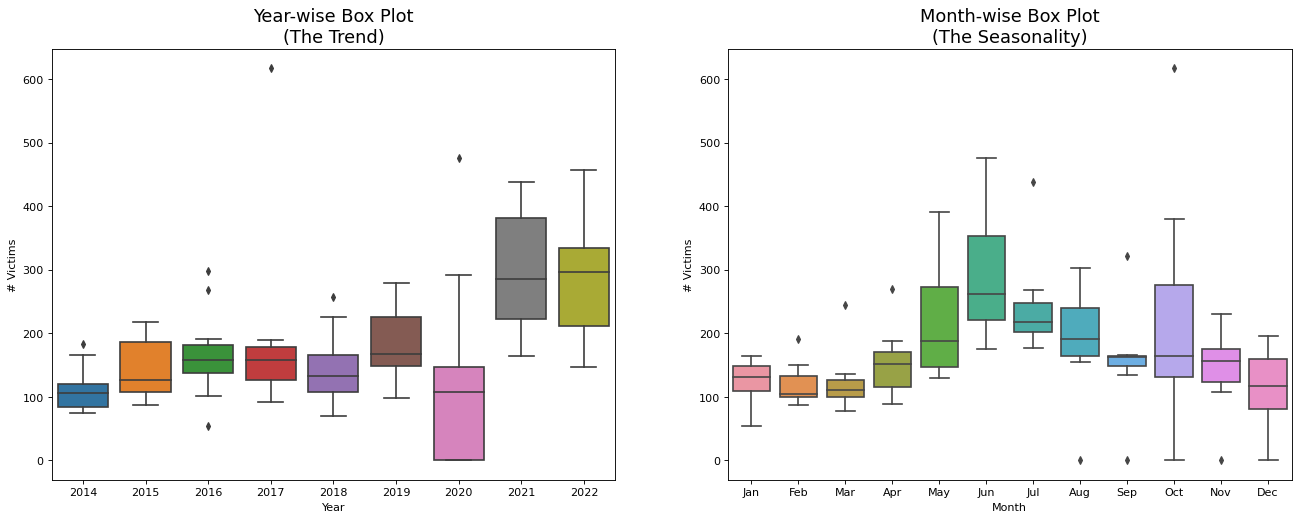

In [23]:
df_ts['Month'] = [d.strftime('%b') for d in df_ts.index]
years = df_ts['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='# Victims', data=df_ts, ax=axes[0])
sns.boxplot(x='Month', y='# Victims', data=df_ts.loc[~df_ts.Year.isin([2014, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

In [24]:
df_ts.head(10)["# Victims"]

Month Ending In
2014-01-31     79
2014-02-28     86
2014-03-31     75
2014-04-30    106
2014-05-31    108
2014-06-30    138
2014-07-31    166
2014-08-31    183
2014-09-30    114
2014-10-31     79
Freq: M, Name: # Victims, dtype: int64

In [25]:
df_ts.info

<bound method DataFrame.info of                  # Killed  # Injured  # Victims  Cumulative Victims Same Year  \
Month Ending In                                                                 
2014-01-31             15         64         79                            79   
2014-02-28             23         63         86                           165   
2014-03-31             13         62         75                           240   
2014-04-30             16         90        106                           346   
2014-05-31             23         85        108                           454   
...                   ...        ...        ...                           ...   
2022-08-31             65        234        299                          2371   
2022-09-30             51        242        293                          2664   
2022-10-31             86        245        331                          2995   
2022-11-30             52        182        234                          3229

In [26]:
z_scores = np.abs((df_ts['# Victims'] - df_ts['# Victims'].mean()) / df_ts['# Victims'].std())

In [27]:
# define a threshold z-score value (e.g., 3)
threshold = 3


In [28]:
# identify and remove any data points with a z-score greater than the threshold
outliers = df_ts[z_scores > threshold]
df_ts1 = df_ts[z_scores <= threshold]

In [29]:
df_ts1.info

<bound method DataFrame.info of                  # Killed  # Injured  # Victims  Cumulative Victims Same Year  \
Month Ending In                                                                 
2014-01-31             15         64         79                            79   
2014-02-28             23         63         86                           165   
2014-03-31             13         62         75                           240   
2014-04-30             16         90        106                           346   
2014-05-31             23         85        108                           454   
...                   ...        ...        ...                           ...   
2022-08-31             65        234        299                          2371   
2022-09-30             51        242        293                          2664   
2022-10-31             86        245        331                          2995   
2022-11-30             52        182        234                          3229

C:\Users\ruvva\AppData\Local\Temp\ipykernel_11116\734117298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts1['Month'] = [d.strftime('%b') for d in df_ts1.index]


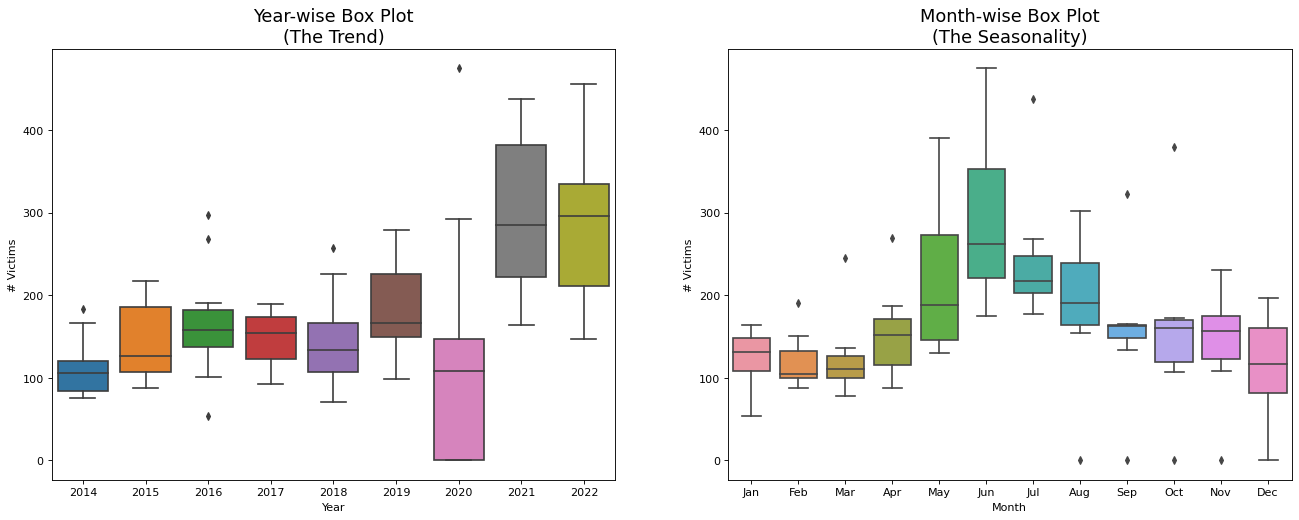

In [30]:
df_ts1['Month'] = [d.strftime('%b') for d in df_ts1.index]
years = df_ts1['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='# Victims', data=df_ts1, ax=axes[0])
sns.boxplot(x='Month', y='# Victims', data=df_ts1.loc[~df_ts1.Year.isin([2014, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

In [31]:
def adfuller_test(df):
    for col in df.columns:
        result = adfuller(df[col])
        labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
        for value, label in zip(result, labels):
            print(f'{col} {label}: {value:.4f}')
        if result[1] <= 0.05:
            print(f'{col}: strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary')
        else:
            print(f'{col}: weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary')
        print('\n')

In [32]:
adfuller_test(df_ts1[['# Injured', '# Killed', '# Victims']])

# Injured ADF Test Statistic: -1.0596
# Injured p-value: 0.7309
# Injured #Lags Used: 10.0000
# Injured Number of Observations Used: 96.0000
# Injured: weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


# Killed ADF Test Statistic: -4.0809
# Killed p-value: 0.0010
# Killed #Lags Used: 1.0000
# Killed Number of Observations Used: 105.0000
# Killed: strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary


# Victims ADF Test Statistic: -3.9923
# Victims p-value: 0.0015
# Victims #Lags Used: 0.0000
# Victims Number of Observations Used: 106.0000
# Victims: strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary




#### As the data is stationary we can proceed with model development

#### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

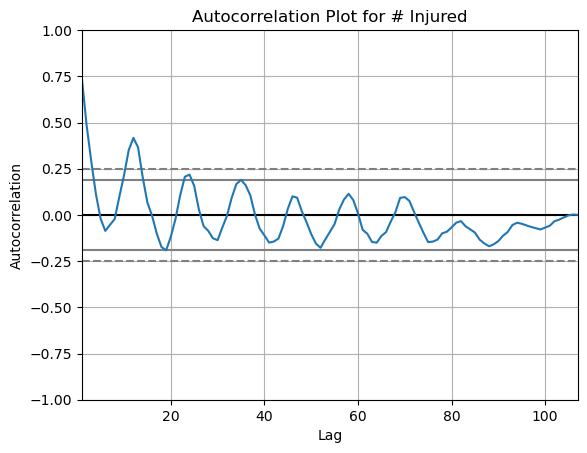

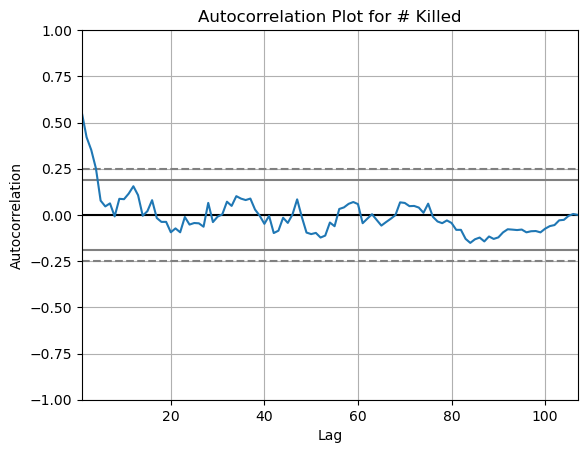

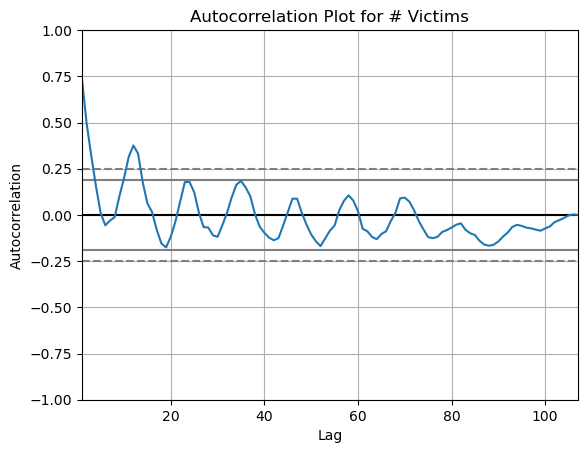

In [33]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

# plot autocorrelation for '# Injured'
autocorrelation_plot(df_ts1['# Injured'])
plt.title('Autocorrelation Plot for # Injured')
plt.show()

# plot autocorrelation for '# Killed'
autocorrelation_plot(df_ts1['# Killed'])
plt.title('Autocorrelation Plot for # Killed')
plt.show()


# plot autocorrelation for '# Victims'
autocorrelation_plot(df_ts1['# Victims'])
plt.title('Autocorrelation Plot for # Victims')
plt.show()


In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

C:\Users\ruvva\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


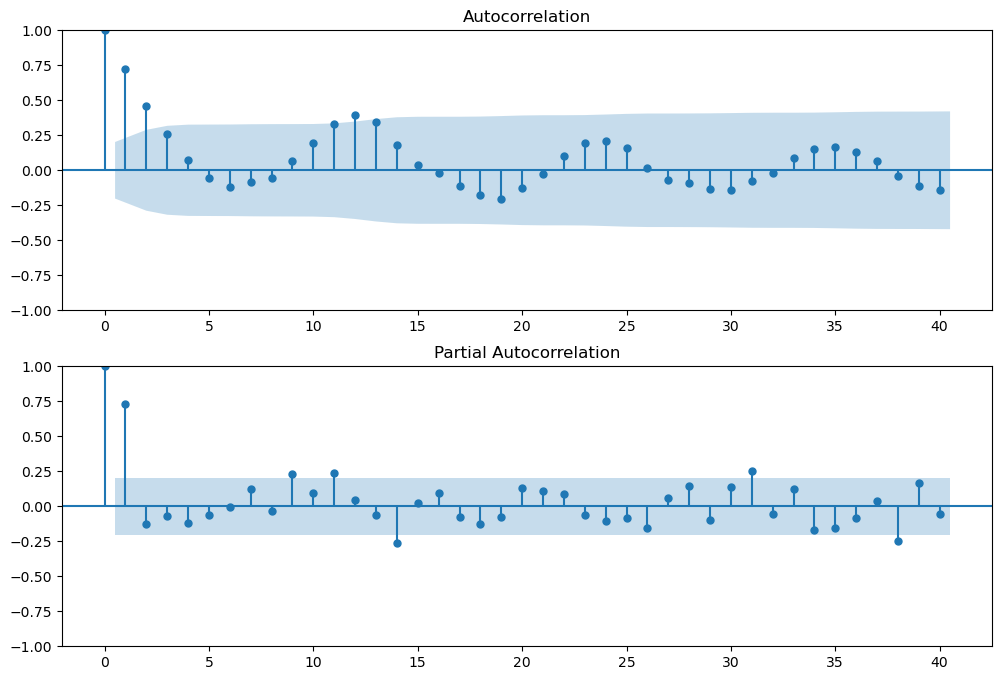

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_ts1['# Injured'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_ts1['# Injured'].iloc[13:],lags=40,ax=ax2)

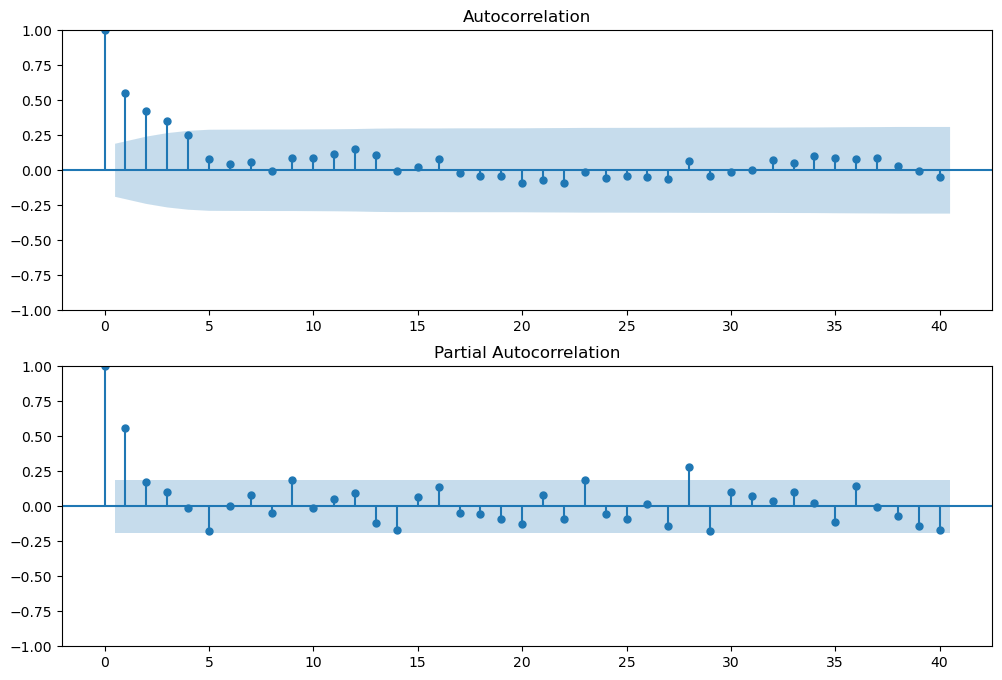

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_ts1['# Killed'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_ts1['# Killed'],lags=40,ax=ax2)

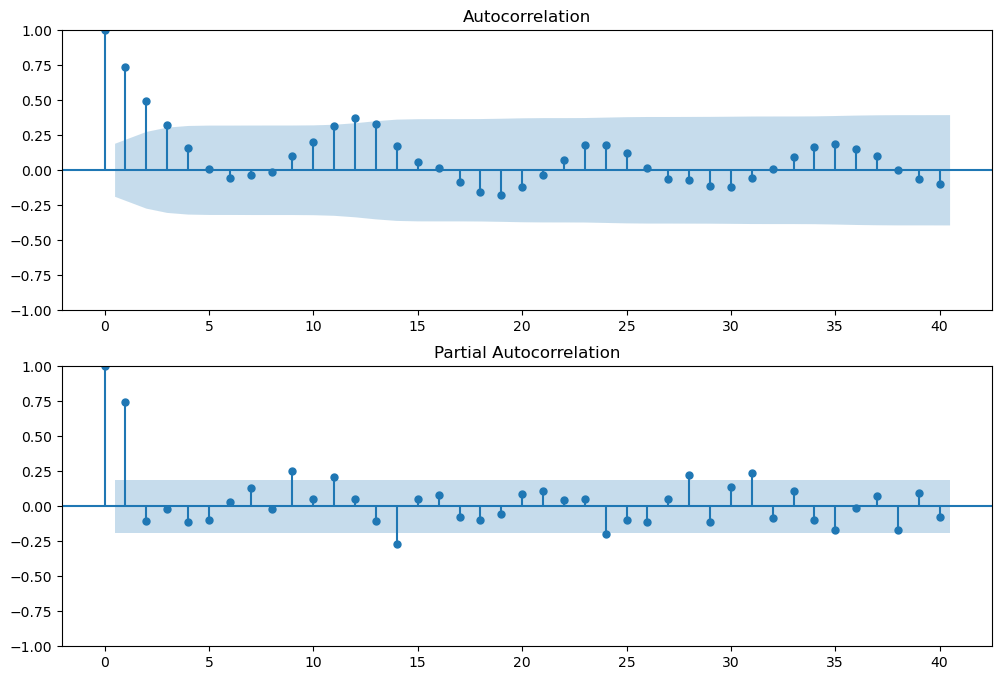

In [37]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_ts1['# Victims'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_ts1['# Victims'],lags=40,ax=ax2)

### Data Processing

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


In [39]:
# Split the data into train, test, and validation sets
train_size = int(len(df_ts1) * 0.6)  # 60% for training
test_size = int(len(df_ts1) * 0.2)   # 20% for testing
valid_size = len(df_ts1) - train_size - test_size  # Remaining for validation


In [40]:
train_set = df_ts1[:train_size]
test_set = df_ts1[train_size:train_size+test_size]
valid_set = df_ts1[train_size+test_size:]

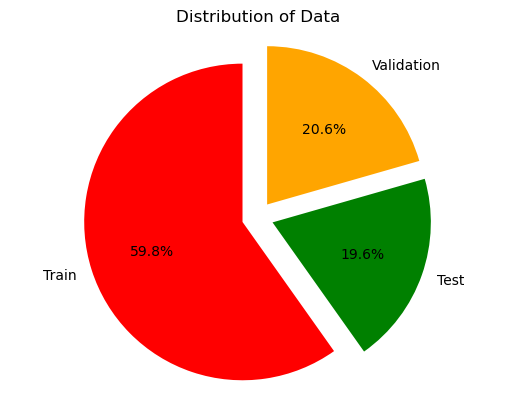

In [41]:
# Plot the distribution using a pie chart
labels = ['Train', 'Test', 'Validation']
sizes = [train_size, test_size, valid_size]
colors = ['red', 'green', 'orange']
explode = (0.1, 0.1, 0.1)
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Data')
plt.show()

In [42]:
dfs1 = [df_ts1, train_set, test_set, valid_set]

for df in dfs1:
    print(df.shape)

(107, 6)
(64, 6)
(21, 6)
(22, 6)


## ARIMA

In [43]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_set['# Victims'], order=(1, 1, 1))
model_fit = model.fit()

C:\Users\ruvva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ruvva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ruvva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              # Victims   No. Observations:                   64
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -327.845
Date:                Sat, 06 May 2023   AIC                            661.691
Time:                        20:36:49   BIC                            668.120
Sample:                             0   HQIC                           664.219
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5840      0.157      3.725      0.000       0.277       0.891
ma.L1         -0.9833      0.151     -6.514      0.000      -1.279      -0.687
sigma2      1878.0912    252.370      7.442      0.000    1383.456    2372.727
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                16.60
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.96
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ruvva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ruvva\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='Month Ending In'>

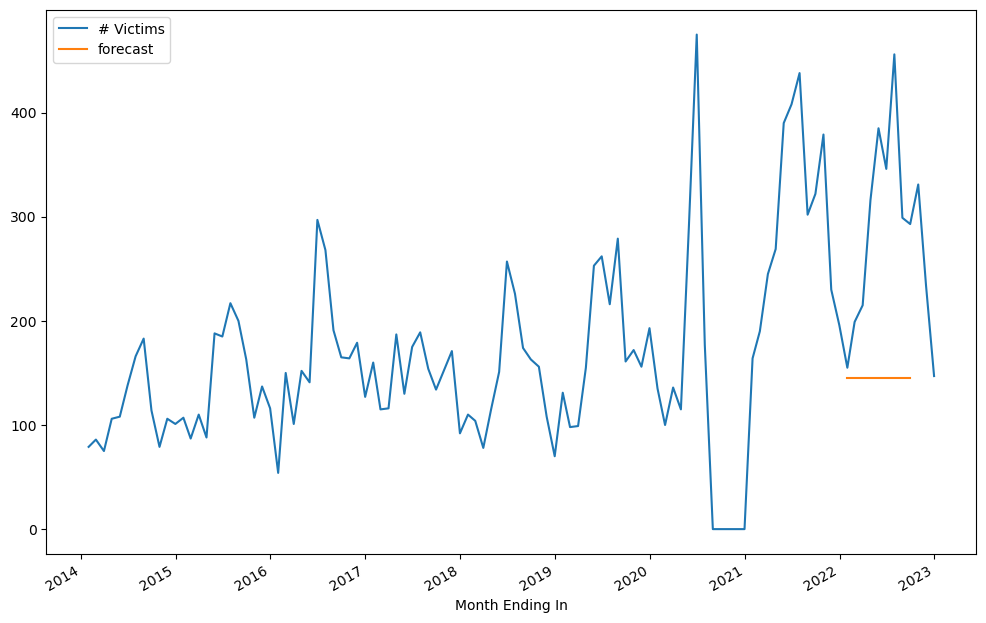

In [45]:
df_ts1 = df_ts1.reset_index()
df_ts1['forecast'] = model_fit.predict(start=95, end=103, dynamic=True)
df_ts1[['Month Ending In', '# Victims', 'forecast']].plot(x='Month Ending In', figsize=(12,8))

## SARIMA

In [46]:
train_set = df_ts1[:train_size]
test_set = df_ts1[train_size:train_size+test_size]
valid_set = df_ts1[train_size+test_size:]

In [47]:
# Train the SARIMA model on the train set
model = sm.tsa.statespace.SARIMAX(train_set['# Victims'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
results = model.fit()

In [48]:
# Generate forecasts on the test set using the trained model
test_forecast = results.forecast(steps=len(test_set))

# Generate forecasts on the validation set using the trained model
valid_forecast = results.forecast(steps=len(valid_set))

In [49]:
# Evaluate the model's performance on the train set
train_rmse = np.sqrt(((results.fittedvalues - train_set['# Victims']) ** 2).mean())
train_mae = np.abs(results.fittedvalues - train_set['# Victims']).mean()
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")

Train RMSE: 45.72
Train MAE: 35.93


In [50]:
# Evaluate the model's performance on the test set
test_rmse = np.sqrt(((test_forecast - test_set['# Victims']) ** 2).mean())
test_mae = np.abs(test_forecast - test_set['# Victims']).mean()
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")


Test RMSE: 103.37
Test MAE: 75.75


In [51]:
# Evaluate the model's performance on the validation set
valid_rmse = np.sqrt(((valid_forecast - valid_set['# Victims']) ** 2).mean())
valid_mae = np.abs(valid_forecast - valid_set['# Victims']).mean()
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Validation MAE: {valid_mae:.2f}")

Validation RMSE: 122.74
Validation MAE: 122.74


C:\Users\ruvva\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:>

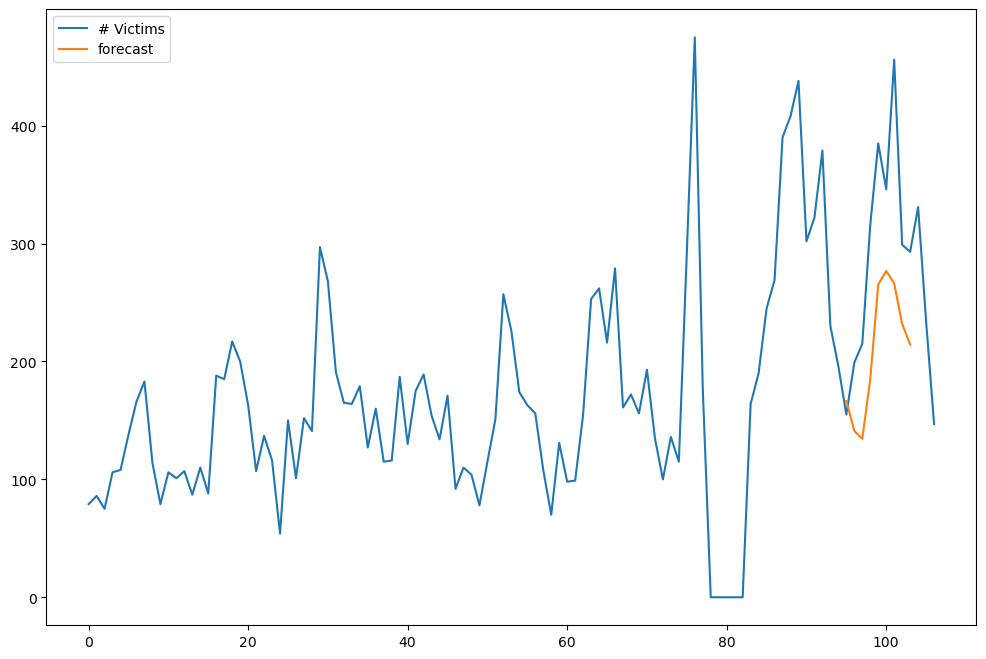

In [52]:
df_ts1['forecast']=results.predict(start=95,end=103,dynamic=True)
df_ts1[['# Victims','forecast']].plot(figsize=(12,8))